In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv
import matplotlib.pyplot as plt
from random import randint


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from node2vec import Node2Vec as n2v

e:\Data Mining\DM_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


generate Facebook network

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


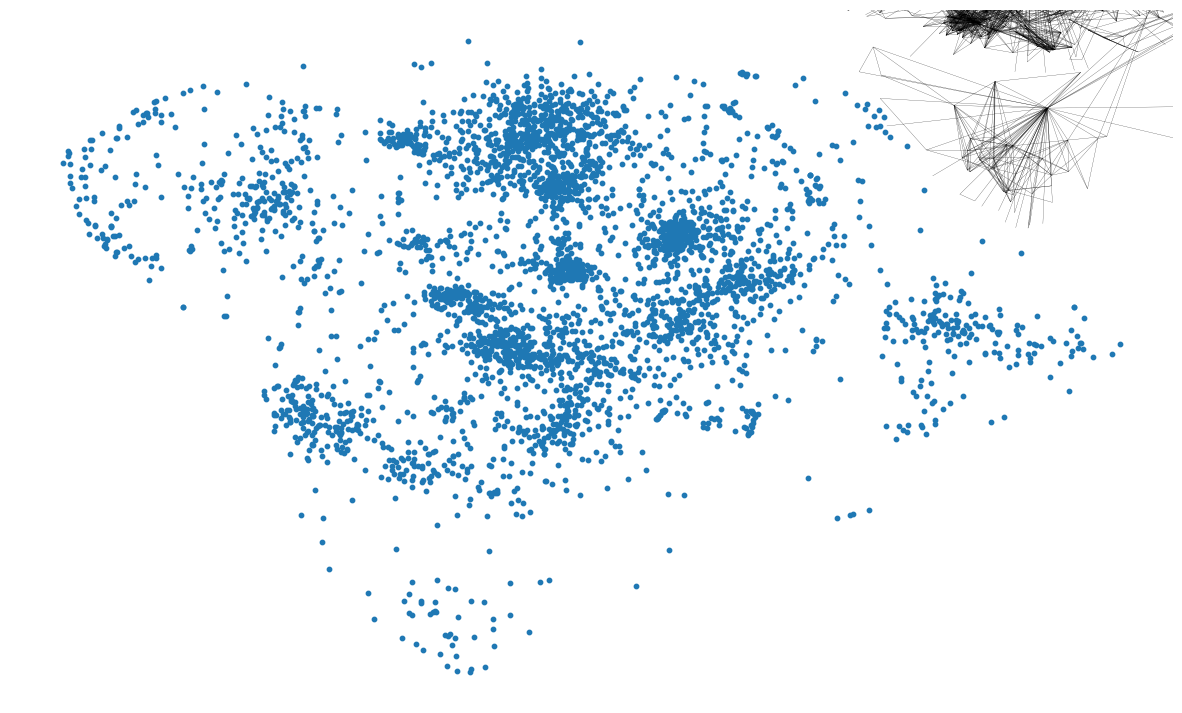

In [7]:
def generate_network(df, node_col = 'person_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'person_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

# research_df = pd.read_csv('./arxiv_data.csv')

# all_tp = research_df.explode('all_topics').copy()

# tp_nx = generate_network(
#     all_tp, 
#     node_col = 'person_id', 
#     edge_col = 'all_topics'
# )

# print(nx.info(tp_nx))

facebook = pd.read_csv(
    "./facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
# print(facebook.head)

G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

print(nx.info(G))

Generate Embeddings using node2vec

In [8]:
g_emb = n2v(G, dimensions=16)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

# create embeddings dataframe
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

print(emb_df.head())

Generating walks (CPU: 1): 100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


          0         1         2         3
0 -1.098163  1.571132  4.742053  0.588845
1 -2.828637  1.206735  5.874706  0.784773
2 -1.377899  2.008487  5.151791  2.033337
3 -1.297150  0.926561  5.600526 -0.602847
4  0.499461  2.130187  5.827752  0.696163


Recommendation with Distance meausure


In [9]:
def predict_links(G, df, person_id, N):
    '''
    This function will predict the top N links a node (person_id) should be connected with
    which it is not already connected with in G.
    
    params:
        G (Netowrkx Graph) : The network used to create the embeddings
        df (DataFrame) : The dataframe which has embeddings associated to each node
        person_id (Integer) : The article you're interested 
        N (Integer) : The number of recommended links you want to return
        
    returns:
        This function will return a list of nodes the input node should be connected with.
    '''
    
    # separate target article with all others
    article = df[df.index == person_id]
    
    # other articles are all articles which the current doesn't have an edge connecting
    all_nodes = G.nodes()
    other_nodes = [n for n in all_nodes if n not in list(G.adj[person_id]) + [person_id]]
    other_articles = df[df.index.isin(other_nodes)]
    
    # get similarity of current reader and all other readers
    sim = cosine_similarity(article, other_articles)[0].tolist()
    idx = other_articles.index.tolist()
    
    # create a similarity dictionary for this user w.r.t all other users
    idx_sim = dict(zip(idx, sim))
    idx_sim = sorted(idx_sim.items(), key=lambda x: x[1], reverse=True)
    
    similar_articles = idx_sim[:N]
    articles = [art[0] for art in similar_articles]
    return articles
  
predict_links(G = G, df = emb_df, person_id = 7, N = 10)

[48, 88, 178, 260, 5, 73, 317, 336, 206, 1]

Vizualize Embeddings


[]

<Figure size 640x480 with 0 Axes>

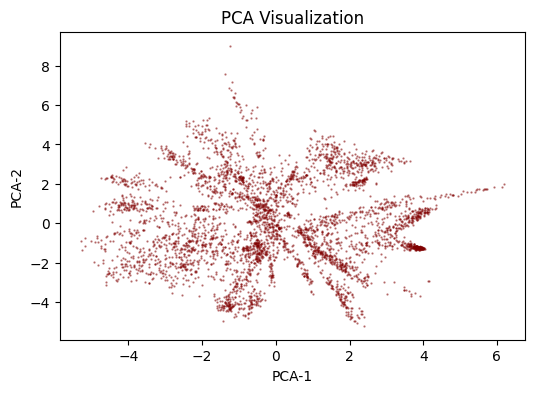

In [10]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4))
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()